In [1]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

/home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK3c106IValue23reportToTensorTypeErrorEv
  warn(f"Failed to load image Python extension: {e}")


# Training Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=1000
dims_latent = 32                            
learning_rate=1e-3
batch_size=16                                        
device=set_device("cuda", 0)
train_size=0.00108
# train_size=0.00108 / 64

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1DFFT(reduction="sum", std=3e-9, store_filters="norm", epsilon=3e-15)
switch_at_epoch = 0 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse  

No GPU available! Running on CPU


In [3]:
# Training loop
def train_model(model, optimizer, train_loader, nepochs=150, switch_at_epoch=0, vis_frequency=10):
    print("\n\nTraining started ...")
    all_loss, all_mse, all_kl = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            if epoch < switch_at_epoch:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, l2loss, device=device)
            else:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, awi1D, device=device)
            epoch_mse = validate(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
            all_loss.append(epoch_loss.item())
            all_mse.append(epoch_mse.item())
            all_kl.append(epoch_kl.item())
            bar.update(epoch)
            
            # Metric logs and plots
            log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_awi1d_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
            if epoch % vis_frequency == 0 or epoch==nepochs-1:
                idx = random.randint(0, len(trainds))
                idx=-1
                X = trainds[idx][0].unsqueeze(0).to(device)
                recon = model(X)
                if isinstance(recon, tuple): recon = recon[0] # in case model returns more than one output, recon must be the first
                
                f = awi1D(recon, X)
                v, T = awi1D.filters[0], awi1D.T

                print("\n", log)
                print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())


                plot_grad_flow(model.named_parameters())

                fig, axs = plt.subplots(2,3)#, figsize=(15,15))
                axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0., vmax=1.)
                axs[0, 0].set_title("recon")

                axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0., vmax=1.)
                axs[0, 1].set_title("orig")

                axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
                axs[0, 2].set_title("diff")

                axs[1, 0].plot(v.detach().cpu().numpy())
                axs[1, 0].plot(T.flatten().detach().cpu().numpy(), "--")
                axs[1, 0].set_title("T-1D vs v-1D")
                axs[1, 0].set_ylim(None, 1.1)

                axs[1, 1].plot((T.flatten() - v).detach().cpu().numpy())
                axs[1, 1].set_title("T1D - v1D")
                axs[1, 1].set_ylim(None, 1.1)
                plt.show()

                fig, axs = plt.subplots(1,3, figsize=(7, 3))
                axs[0].plot(all_loss, label="aw_loss1d")
                axs[0].legend()
                axs[0].set_xlabel("epoch")
                axs[1].plot(all_mse, label="mse")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[2].plot(all_kl, label="kl_loss")
                axs[2].legend()
                axs[2].set_xlabel("epoch")
                plt.show()

# MNIST Example

## Datasets and Dataloaders

In [4]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
])

ds = MNIST("./", download=True, train=True, transform=train_transform)
try:
    shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
    train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
except:
    train_idx=[7]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())


Trainable Images: 64
torch.Size([1, 1, 28, 28]) 0.0 0.9960784316062927


## Autoencoder FC

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.23150289058685303, 'train_awi1d_loss': 2.822906732559204, 'train_kl_loss': 0.0}
 argidx T, v:  783 440


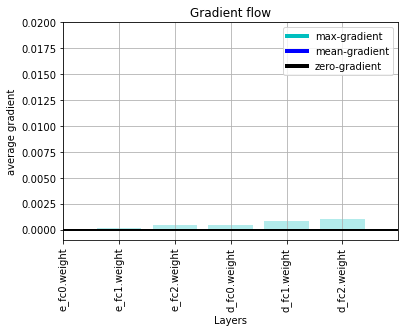

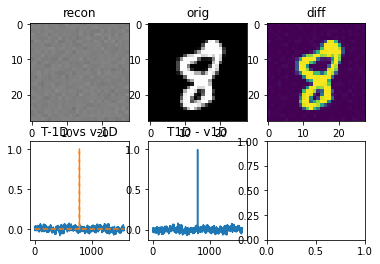

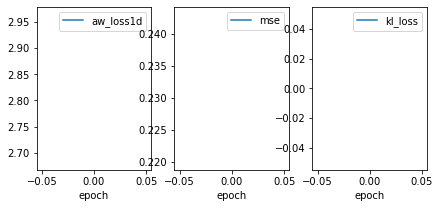

  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:44
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:12
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:00
  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:54
  5% (5 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:50
  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:37
  7% (7 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:37
  8% (8 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:37
  9% (9 of 100) |##                      | Elapsed Time: 0:00:04 ETA:   0:00:36
 10% (10 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:36
 11% (11 of 100) |##                     | Elapsed Time: 0:00:05 ETA:   0:00:36
 12% (12 of 100) |##                     | Elapsed Time: 0:00:05 ETA:   0:00:35
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.23773840069770813, 'train_awi1d_loss': 2.419116973876953, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


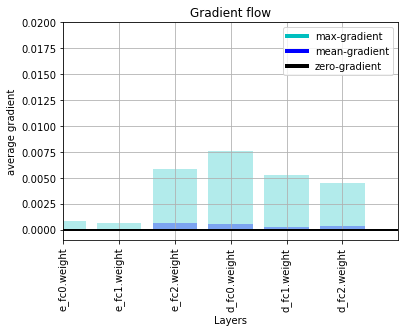

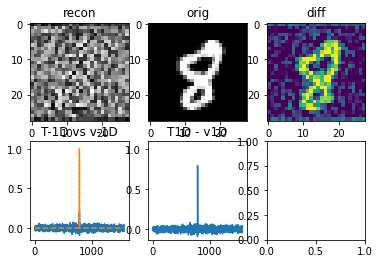

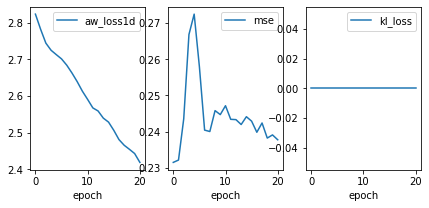

 21% (21 of 100) |####                   | Elapsed Time: 0:00:09 ETA:   0:00:46
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:10 ETA:   0:00:45
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:10 ETA:   0:00:44
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:11 ETA:   0:00:43
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:11 ETA:   0:00:40
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:11 ETA:   0:00:38
 27% (27 of 100) |######                 | Elapsed Time: 0:00:12 ETA:   0:00:29
 28% (28 of 100) |######                 | Elapsed Time: 0:00:12 ETA:   0:00:29
 29% (29 of 100) |######                 | Elapsed Time: 0:00:13 ETA:   0:00:28
 30% (30 of 100) |######                 | Elapsed Time: 0:00:13 ETA:   0:00:28
 31% (31 of 100) |#######                | Elapsed Time: 0:00:13 ETA:   0:00:28
 32% (32 of 100) |#######                | Elapsed Time: 0:00:14 ETA:   0:00:27
 33% (33 of 100) |#######               


 {'epoch': 40, 'train_mse': 0.22803281247615814, 'train_awi1d_loss': 2.1595842838287354, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


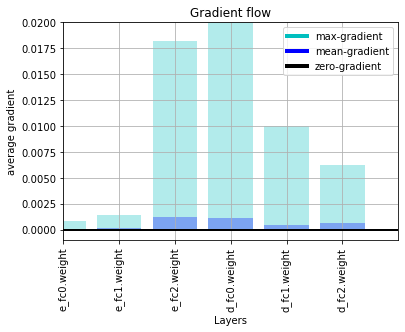

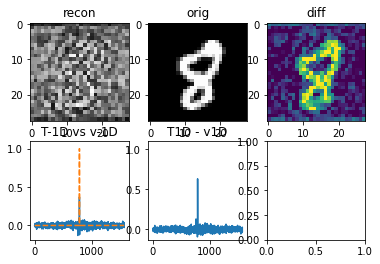

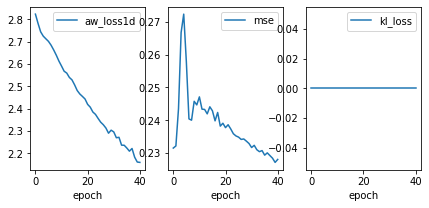

 41% (41 of 100) |#########              | Elapsed Time: 0:00:18 ETA:   0:00:33
 42% (42 of 100) |#########              | Elapsed Time: 0:00:19 ETA:   0:00:40
 43% (43 of 100) |#########              | Elapsed Time: 0:00:19 ETA:   0:00:39
 44% (44 of 100) |##########             | Elapsed Time: 0:00:19 ETA:   0:00:34
 45% (45 of 100) |##########             | Elapsed Time: 0:00:20 ETA:   0:00:27
 46% (46 of 100) |##########             | Elapsed Time: 0:00:21 ETA:   0:00:27
 47% (47 of 100) |##########             | Elapsed Time: 0:00:21 ETA:   0:00:27
 48% (48 of 100) |###########            | Elapsed Time: 0:00:22 ETA:   0:00:29
 49% (49 of 100) |###########            | Elapsed Time: 0:00:22 ETA:   0:00:28
 50% (50 of 100) |###########            | Elapsed Time: 0:00:23 ETA:   0:00:27
 51% (51 of 100) |###########            | Elapsed Time: 0:00:23 ETA:   0:00:27
 52% (52 of 100) |###########            | Elapsed Time: 0:00:24 ETA:   0:00:27
 53% (53 of 100) |############          


 {'epoch': 60, 'train_mse': 0.22221872210502625, 'train_awi1d_loss': 1.985581398010254, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


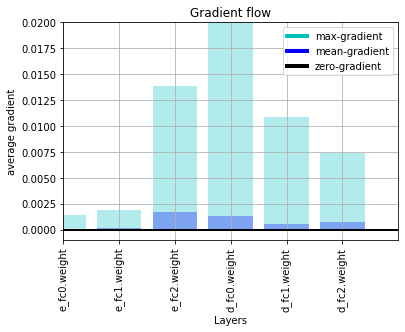

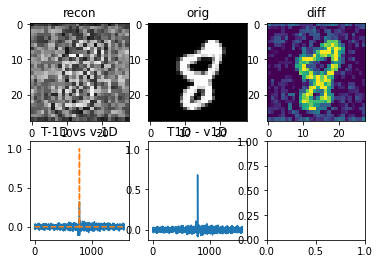

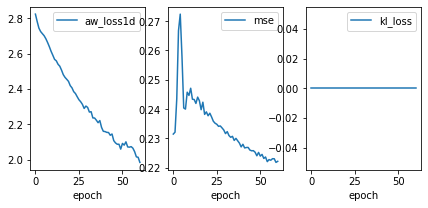

 61% (61 of 100) |##############         | Elapsed Time: 0:00:30 ETA:   0:00:42
 62% (62 of 100) |##############         | Elapsed Time: 0:00:30 ETA:   0:00:40
 63% (63 of 100) |##############         | Elapsed Time: 0:00:31 ETA:   0:00:33
 64% (64 of 100) |##############         | Elapsed Time: 0:00:32 ETA:   0:00:29
 65% (65 of 100) |##############         | Elapsed Time: 0:00:32 ETA:   0:00:20
 66% (66 of 100) |###############        | Elapsed Time: 0:00:33 ETA:   0:00:19
 67% (67 of 100) |###############        | Elapsed Time: 0:00:33 ETA:   0:00:18
 68% (68 of 100) |###############        | Elapsed Time: 0:00:34 ETA:   0:00:17
 69% (69 of 100) |###############        | Elapsed Time: 0:00:34 ETA:   0:00:16
 70% (70 of 100) |################       | Elapsed Time: 0:00:35 ETA:   0:00:15
 71% (71 of 100) |################       | Elapsed Time: 0:00:35 ETA:   0:00:15
 72% (72 of 100) |################       | Elapsed Time: 0:00:36 ETA:   0:00:14
 73% (73 of 100) |################      


 {'epoch': 80, 'train_mse': 0.2174210250377655, 'train_awi1d_loss': 1.8787813186645508, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


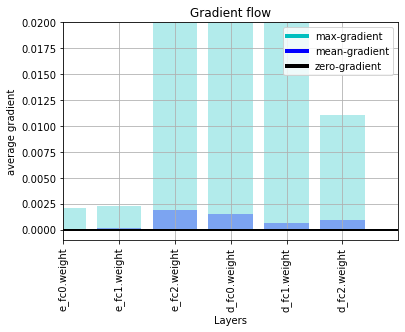

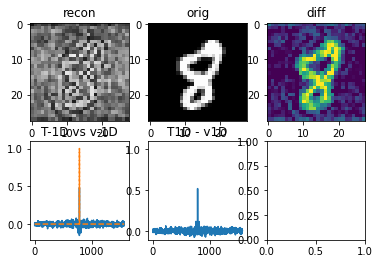

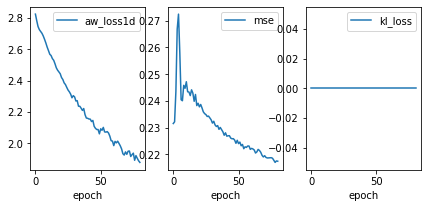

 81% (81 of 100) |##################     | Elapsed Time: 0:00:42 ETA:   0:00:19
 82% (82 of 100) |##################     | Elapsed Time: 0:00:43 ETA:   0:00:19
 83% (83 of 100) |###################    | Elapsed Time: 0:00:43 ETA:   0:00:15
 84% (84 of 100) |###################    | Elapsed Time: 0:00:44 ETA:   0:00:12
 85% (85 of 100) |###################    | Elapsed Time: 0:00:44 ETA:   0:00:08
 86% (86 of 100) |###################    | Elapsed Time: 0:00:45 ETA:   0:00:07
 87% (87 of 100) |####################   | Elapsed Time: 0:00:45 ETA:   0:00:07
 88% (88 of 100) |####################   | Elapsed Time: 0:00:46 ETA:   0:00:06
 89% (89 of 100) |####################   | Elapsed Time: 0:00:46 ETA:   0:00:06
 90% (90 of 100) |####################   | Elapsed Time: 0:00:47 ETA:   0:00:05
 91% (91 of 100) |####################   | Elapsed Time: 0:00:48 ETA:   0:00:05
 92% (92 of 100) |#####################  | Elapsed Time: 0:00:48 ETA:   0:00:04
 93% (93 of 100) |##################### 


 {'epoch': 99, 'train_mse': 0.2128419578075409, 'train_awi1d_loss': 1.8082659244537354, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


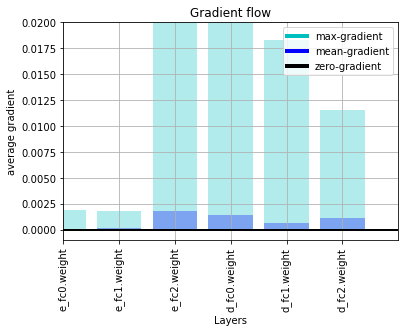

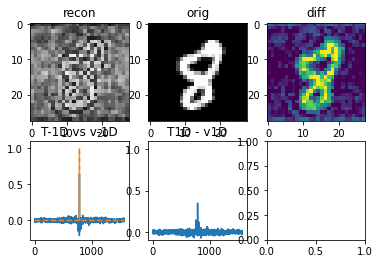

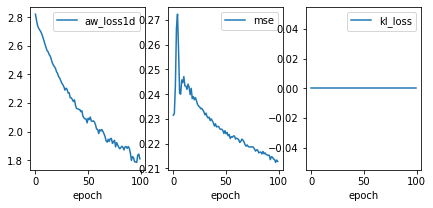

100% (100 of 100) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


In [5]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)



## Visualise Loss Landscape of Autoencoder (FC)

Train Subset len:  16
Angle between x_dir and y_dir: 90.01 °


N/A% (0 of 625) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:42
  0% (2 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:39
  0% (3 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:34
  0% (4 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:31
  0% (5 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:29
  0% (6 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:30
  1% (7 of 625) |                        | Elapsed Time: 0:00:01 ETA:   0:01:31
  1% (8 of 625) |                        | Elapsed Time: 0:00:01 ETA:   0:01:33
  1% (9 of 625) |                        | Elapsed Time: 0:00:01 ETA:   0:01:35
  1% (10 of 625) |                       | Elapsed Time: 0:00:01 ETA:   0:01:36
  1% (11 of 625) |                       | Elapsed Time: 0:00:01 ETA:   0:01:36
  1% (12 of 625) |                      

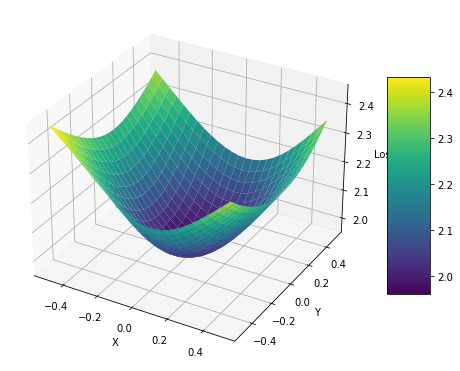

In [6]:
train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Train Subset len: ", len(train_subset))
xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)

## Variational Autoencoder (FC)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.23181948065757751, 'train_awi1d_loss': 2.823035478591919, 'train_kl_loss': 258.0357971191406}
 argidx T, v:  783 1083


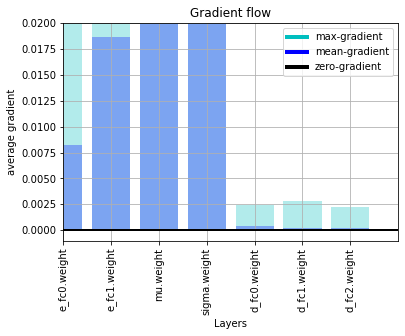

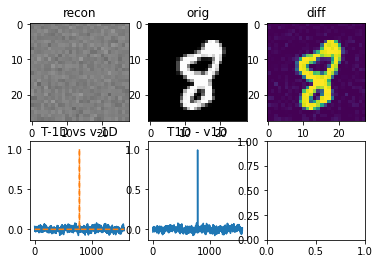

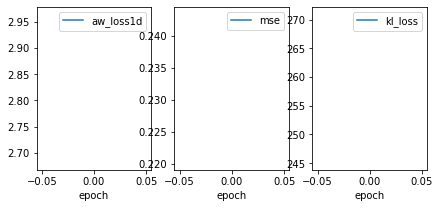

  1% (1 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:03:34
  2% (2 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:02:35
  3% (3 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:02:10
  4% (4 of 100) |                        | Elapsed Time: 0:00:05 ETA:   0:01:32
  5% (5 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:29
  6% (6 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:33
  7% (7 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:01:31
  8% (8 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:01:24
  9% (9 of 100) |##                      | Elapsed Time: 0:00:09 ETA:   0:01:19
 10% (10 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:16
 11% (11 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:24
 12% (12 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:19
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.25187501311302185, 'train_awi1d_loss': 2.700918197631836, 'train_kl_loss': 256.0057678222656}
 argidx T, v:  783 631


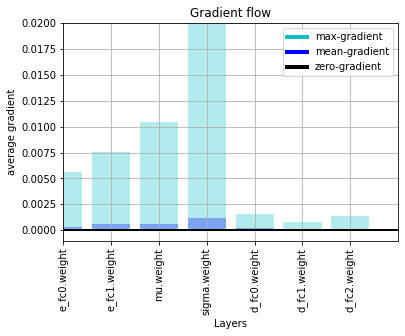

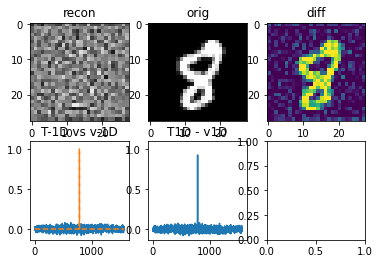

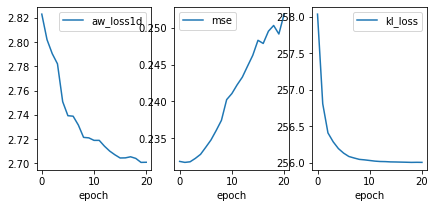

 21% (21 of 100) |####                   | Elapsed Time: 0:00:21 ETA:   0:02:41
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:02:02
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:23 ETA:   0:01:42
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:24 ETA:   0:01:15
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:25 ETA:   0:01:08
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:26 ETA:   0:01:09
 27% (27 of 100) |######                 | Elapsed Time: 0:00:27 ETA:   0:01:08
 28% (28 of 100) |######                 | Elapsed Time: 0:00:28 ETA:   0:01:12
 29% (29 of 100) |######                 | Elapsed Time: 0:00:28 ETA:   0:01:06
 30% (30 of 100) |######                 | Elapsed Time: 0:00:29 ETA:   0:01:03
 31% (31 of 100) |#######                | Elapsed Time: 0:00:30 ETA:   0:00:53
 32% (32 of 100) |#######                | Elapsed Time: 0:00:31 ETA:   0:00:55
 33% (33 of 100) |#######               


 {'epoch': 40, 'train_mse': 0.25875478982925415, 'train_awi1d_loss': 2.6955747604370117, 'train_kl_loss': 256.00323486328125}
 argidx T, v:  783 783


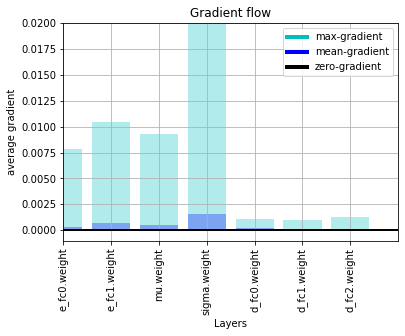

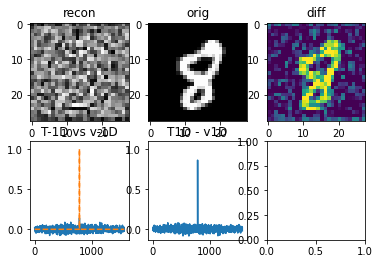

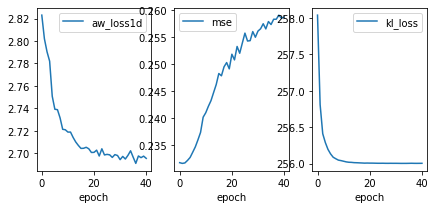

 41% (41 of 100) |#########              | Elapsed Time: 0:00:41 ETA:   0:02:25
 42% (42 of 100) |#########              | Elapsed Time: 0:00:42 ETA:   0:01:41
 43% (43 of 100) |#########              | Elapsed Time: 0:00:43 ETA:   0:01:19
 44% (44 of 100) |##########             | Elapsed Time: 0:00:44 ETA:   0:00:49
 45% (45 of 100) |##########             | Elapsed Time: 0:00:45 ETA:   0:00:47
 46% (46 of 100) |##########             | Elapsed Time: 0:00:46 ETA:   0:00:50
 47% (47 of 100) |##########             | Elapsed Time: 0:00:46 ETA:   0:00:44
 48% (48 of 100) |###########            | Elapsed Time: 0:00:47 ETA:   0:00:41
 49% (49 of 100) |###########            | Elapsed Time: 0:00:48 ETA:   0:00:40
 50% (50 of 100) |###########            | Elapsed Time: 0:00:49 ETA:   0:00:42
 51% (51 of 100) |###########            | Elapsed Time: 0:00:50 ETA:   0:00:42
 52% (52 of 100) |###########            | Elapsed Time: 0:00:51 ETA:   0:00:44
 53% (53 of 100) |############          


 {'epoch': 60, 'train_mse': 0.2602173089981079, 'train_awi1d_loss': 2.687716007232666, 'train_kl_loss': 256.0035400390625}
 argidx T, v:  783 783


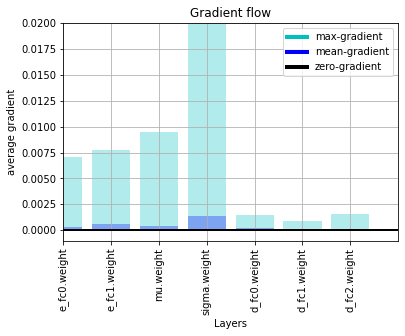

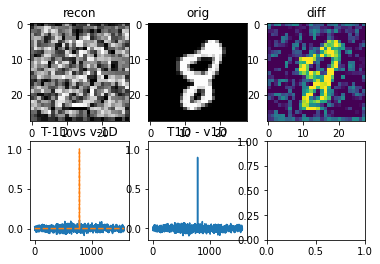

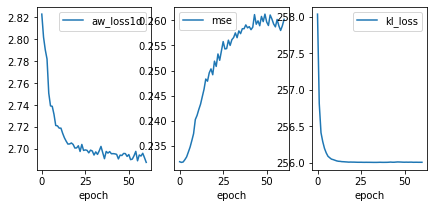

 61% (61 of 100) |##############         | Elapsed Time: 0:01:01 ETA:   0:01:26
 62% (62 of 100) |##############         | Elapsed Time: 0:01:01 ETA:   0:00:56
 63% (63 of 100) |##############         | Elapsed Time: 0:01:02 ETA:   0:00:48
 64% (64 of 100) |##############         | Elapsed Time: 0:01:03 ETA:   0:00:32
 65% (65 of 100) |##############         | Elapsed Time: 0:01:04 ETA:   0:00:30
 66% (66 of 100) |###############        | Elapsed Time: 0:01:05 ETA:   0:00:25
 67% (67 of 100) |###############        | Elapsed Time: 0:01:05 ETA:   0:00:23
 68% (68 of 100) |###############        | Elapsed Time: 0:01:06 ETA:   0:00:19
 69% (69 of 100) |###############        | Elapsed Time: 0:01:06 ETA:   0:00:16
 70% (70 of 100) |################       | Elapsed Time: 0:01:07 ETA:   0:00:17
 71% (71 of 100) |################       | Elapsed Time: 0:01:08 ETA:   0:00:17
 72% (72 of 100) |################       | Elapsed Time: 0:01:08 ETA:   0:00:19
 73% (73 of 100) |################      


 {'epoch': 80, 'train_mse': 0.2543789744377136, 'train_awi1d_loss': 2.691288709640503, 'train_kl_loss': 256.0081787109375}
 argidx T, v:  783 783


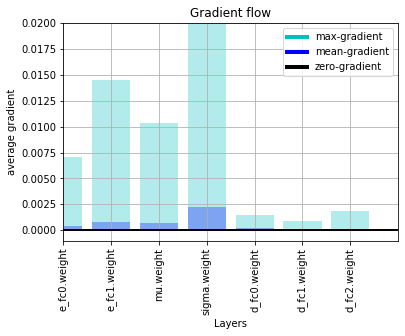

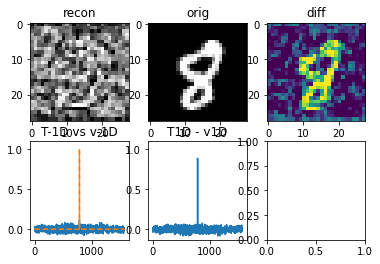

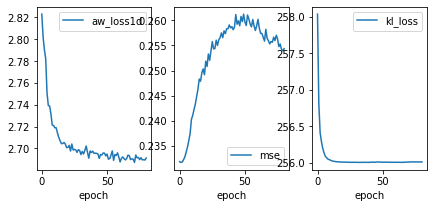

 81% (81 of 100) |##################     | Elapsed Time: 0:01:15 ETA:   0:00:21
 82% (82 of 100) |##################     | Elapsed Time: 0:01:15 ETA:   0:00:20
 83% (83 of 100) |###################    | Elapsed Time: 0:01:16 ETA:   0:00:16
 84% (84 of 100) |###################    | Elapsed Time: 0:01:17 ETA:   0:00:14
 85% (85 of 100) |###################    | Elapsed Time: 0:01:17 ETA:   0:00:09
 86% (86 of 100) |###################    | Elapsed Time: 0:01:18 ETA:   0:00:08
 87% (87 of 100) |####################   | Elapsed Time: 0:01:19 ETA:   0:00:08
 88% (88 of 100) |####################   | Elapsed Time: 0:01:19 ETA:   0:00:07
 89% (89 of 100) |####################   | Elapsed Time: 0:01:20 ETA:   0:00:06
 90% (90 of 100) |####################   | Elapsed Time: 0:01:20 ETA:   0:00:06
 91% (91 of 100) |####################   | Elapsed Time: 0:01:21 ETA:   0:00:05
 92% (92 of 100) |#####################  | Elapsed Time: 0:01:22 ETA:   0:00:04
 93% (93 of 100) |##################### 


 {'epoch': 99, 'train_mse': 0.2506316900253296, 'train_awi1d_loss': 2.690068244934082, 'train_kl_loss': 256.0164489746094}
 argidx T, v:  783 783


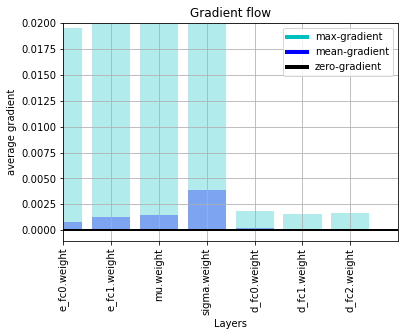

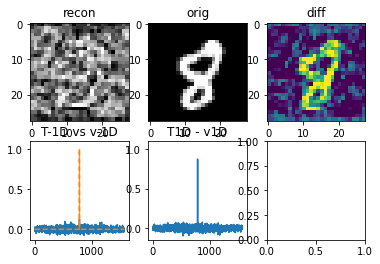

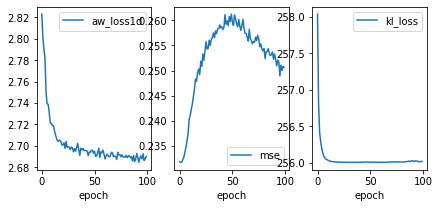

100% (100 of 100) |######################| Elapsed Time: 0:01:27 Time:  0:01:27


In [7]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)
 
# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.2117876559495926, 'train_awi1d_loss': 2.821660041809082, 'train_kl_loss': 0.0}
 argidx T, v:  783 1223


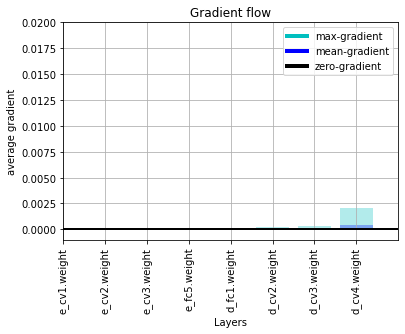

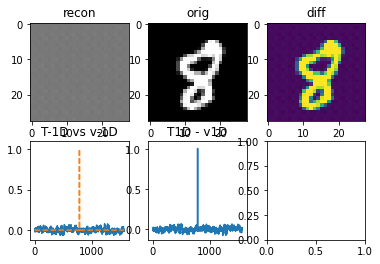

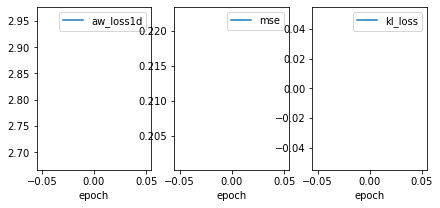

  1% (1 of 100) |                        | Elapsed Time: 0:00:06 ETA:   0:10:06
  2% (2 of 100) |                        | Elapsed Time: 0:00:11 ETA:   0:08:59
  3% (3 of 100) |                        | Elapsed Time: 0:00:17 ETA:   0:08:59
  4% (4 of 100) |                        | Elapsed Time: 0:00:22 ETA:   0:08:39
  5% (5 of 100) |#                       | Elapsed Time: 0:00:28 ETA:   0:09:13
  6% (6 of 100) |#                       | Elapsed Time: 0:00:34 ETA:   0:09:01
  7% (7 of 100) |#                       | Elapsed Time: 0:00:39 ETA:   0:08:35
  8% (8 of 100) |#                       | Elapsed Time: 0:00:45 ETA:   0:08:47
  9% (9 of 100) |##                      | Elapsed Time: 0:00:50 ETA:   0:08:10
 10% (10 of 100) |##                     | Elapsed Time: 0:00:56 ETA:   0:08:19
 11% (11 of 100) |##                     | Elapsed Time: 0:01:02 ETA:   0:08:32
 12% (12 of 100) |##                     | Elapsed Time: 0:01:07 ETA:   0:08:14
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.23502111434936523, 'train_awi1d_loss': 2.6799182891845703, 'train_kl_loss': 0.0}
 argidx T, v:  783 528


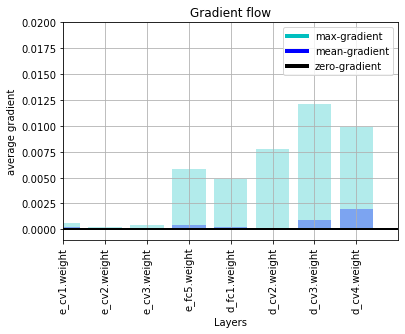

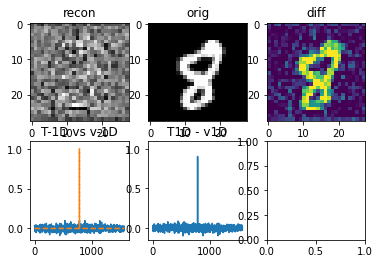

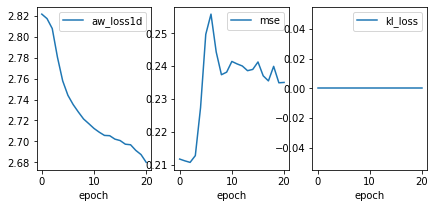

 21% (21 of 100) |####                   | Elapsed Time: 0:01:55 ETA:   0:08:13
 22% (22 of 100) |#####                  | Elapsed Time: 0:02:00 ETA:   0:06:07
 23% (23 of 100) |#####                  | Elapsed Time: 0:02:03 ETA:   0:03:33
 24% (24 of 100) |#####                  | Elapsed Time: 0:02:08 ETA:   0:06:36
 25% (25 of 100) |#####                  | Elapsed Time: 0:02:14 ETA:   0:06:52
 26% (26 of 100) |#####                  | Elapsed Time: 0:02:15 ETA:   0:04:31
 27% (27 of 100) |######                 | Elapsed Time: 0:02:21 ETA:   0:07:05
 28% (28 of 100) |######                 | Elapsed Time: 0:02:27 ETA:   0:06:46
 29% (29 of 100) |######                 | Elapsed Time: 0:02:30 ETA:   0:03:30
 30% (30 of 100) |######                 | Elapsed Time: 0:02:35 ETA:   0:05:52
 31% (31 of 100) |#######                | Elapsed Time: 0:02:40 ETA:   0:06:13
 32% (32 of 100) |#######                | Elapsed Time: 0:02:45 ETA:   0:05:13
 33% (33 of 100) |#######               


 {'epoch': 40, 'train_mse': 0.23164662718772888, 'train_awi1d_loss': 2.5067431926727295, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


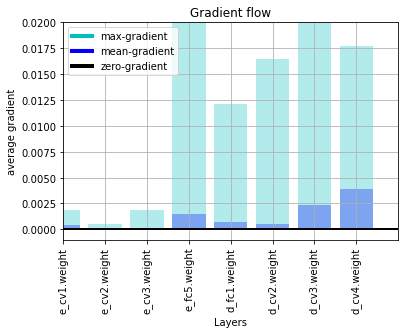

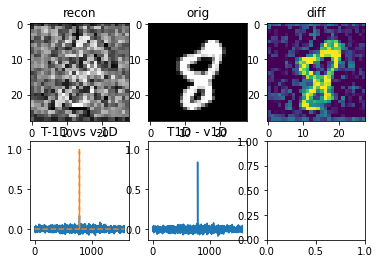

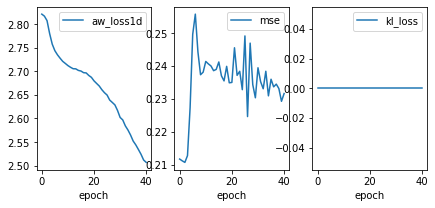

 41% (41 of 100) |#########              | Elapsed Time: 0:03:36 ETA:   0:06:18
 42% (42 of 100) |#########              | Elapsed Time: 0:03:41 ETA:   0:05:07
 43% (43 of 100) |#########              | Elapsed Time: 0:03:47 ETA:   0:05:40
 44% (44 of 100) |##########             | Elapsed Time: 0:03:52 ETA:   0:04:48
 45% (45 of 100) |##########             | Elapsed Time: 0:03:57 ETA:   0:04:33
 46% (46 of 100) |##########             | Elapsed Time: 0:03:58 ETA:   0:02:34
 47% (47 of 100) |##########             | Elapsed Time: 0:04:01 ETA:   0:02:51
 48% (48 of 100) |###########            | Elapsed Time: 0:04:06 ETA:   0:04:13
 49% (49 of 100) |###########            | Elapsed Time: 0:04:11 ETA:   0:03:55
 50% (50 of 100) |###########            | Elapsed Time: 0:04:16 ETA:   0:03:55
 51% (51 of 100) |###########            | Elapsed Time: 0:04:21 ETA:   0:04:26
 52% (52 of 100) |###########            | Elapsed Time: 0:04:26 ETA:   0:04:14
 53% (53 of 100) |############          


 {'epoch': 60, 'train_mse': 0.21056027710437775, 'train_awi1d_loss': 2.3424978256225586, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


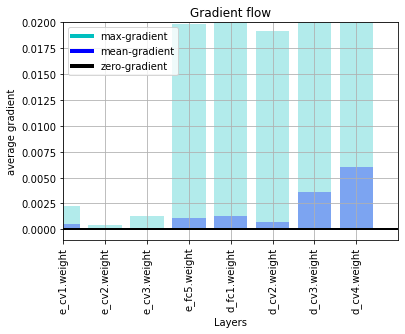

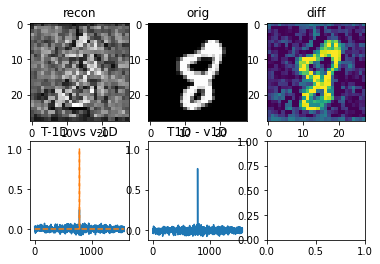

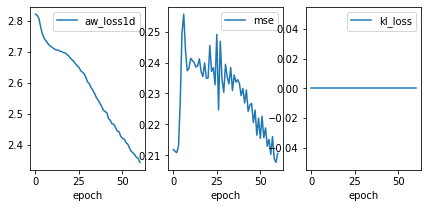

 61% (61 of 100) |##############         | Elapsed Time: 0:05:13 ETA:   0:04:13
 62% (62 of 100) |##############         | Elapsed Time: 0:05:14 ETA:   0:02:26
 63% (63 of 100) |##############         | Elapsed Time: 0:05:18 ETA:   0:02:18
 64% (64 of 100) |##############         | Elapsed Time: 0:05:23 ETA:   0:02:40
 65% (65 of 100) |##############         | Elapsed Time: 0:05:29 ETA:   0:03:34
 66% (66 of 100) |###############        | Elapsed Time: 0:05:35 ETA:   0:03:25
 67% (67 of 100) |###############        | Elapsed Time: 0:05:40 ETA:   0:02:48
 68% (68 of 100) |###############        | Elapsed Time: 0:05:45 ETA:   0:03:02
 69% (69 of 100) |###############        | Elapsed Time: 0:05:51 ETA:   0:02:44
 70% (70 of 100) |################       | Elapsed Time: 0:05:57 ETA:   0:02:54
 71% (71 of 100) |################       | Elapsed Time: 0:06:03 ETA:   0:02:51
 72% (72 of 100) |################       | Elapsed Time: 0:06:07 ETA:   0:02:18
 73% (73 of 100) |################      


 {'epoch': 80, 'train_mse': 0.19183680415153503, 'train_awi1d_loss': 2.2403316497802734, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


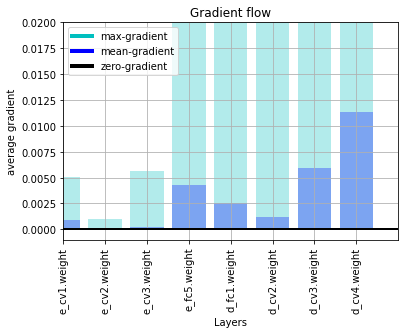

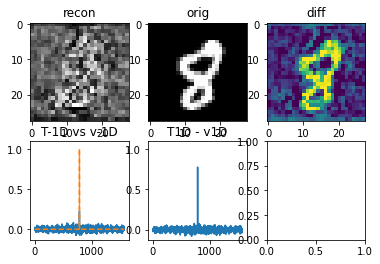

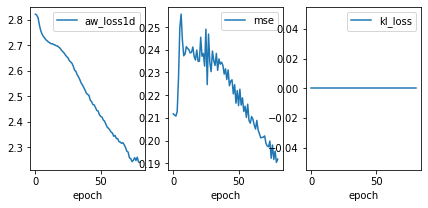

 81% (81 of 100) |##################     | Elapsed Time: 0:06:49 ETA:   0:01:48
 82% (82 of 100) |##################     | Elapsed Time: 0:06:55 ETA:   0:01:36
 83% (83 of 100) |###################    | Elapsed Time: 0:07:01 ETA:   0:01:38
 84% (84 of 100) |###################    | Elapsed Time: 0:07:06 ETA:   0:01:23
 85% (85 of 100) |###################    | Elapsed Time: 0:07:11 ETA:   0:01:25
 86% (86 of 100) |###################    | Elapsed Time: 0:07:16 ETA:   0:01:10
 87% (87 of 100) |####################   | Elapsed Time: 0:07:23 ETA:   0:01:22
 88% (88 of 100) |####################   | Elapsed Time: 0:07:29 ETA:   0:01:17
 89% (89 of 100) |####################   | Elapsed Time: 0:07:35 ETA:   0:00:58
 90% (90 of 100) |####################   | Elapsed Time: 0:07:40 ETA:   0:00:54
 91% (91 of 100) |####################   | Elapsed Time: 0:07:44 ETA:   0:00:31
 92% (92 of 100) |#####################  | Elapsed Time: 0:07:48 ETA:   0:00:34
 93% (93 of 100) |##################### 


 {'epoch': 99, 'train_mse': 0.17346173524856567, 'train_awi1d_loss': 2.1552324295043945, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


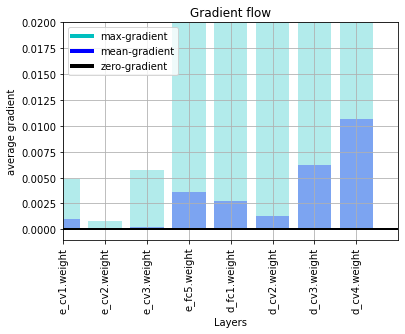

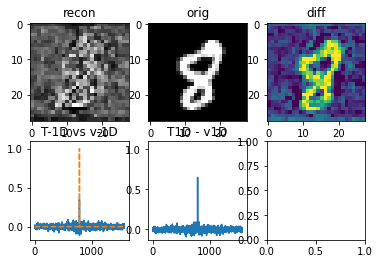

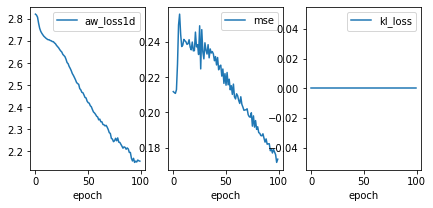

100% (100 of 100) |######################| Elapsed Time: 0:08:26 Time:  0:08:26


In [8]:
# Model and optimisers
model = CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Variational Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.24404606223106384, 'train_awi1d_loss': 2.8227808475494385, 'train_kl_loss': 258.2160339355469}
 argidx T, v:  783 601


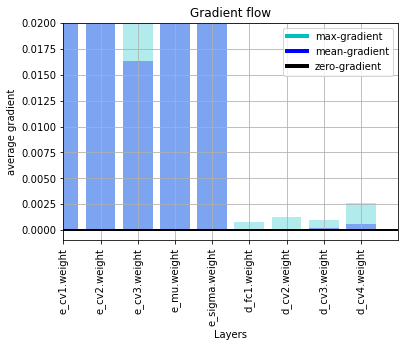

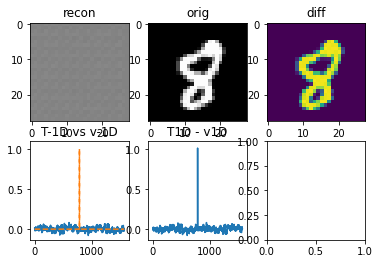

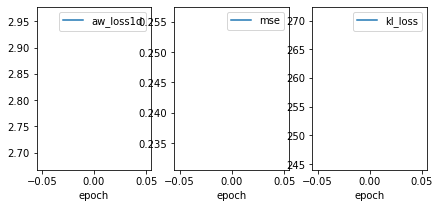

  1% (1 of 100) |                        | Elapsed Time: 0:00:05 ETA:   0:09:33
  2% (2 of 100) |                        | Elapsed Time: 0:00:11 ETA:   0:09:21
  3% (3 of 100) |                        | Elapsed Time: 0:00:16 ETA:   0:08:10
  4% (4 of 100) |                        | Elapsed Time: 0:00:18 ETA:   0:05:30
  5% (5 of 100) |#                       | Elapsed Time: 0:00:22 ETA:   0:07:12
  6% (6 of 100) |#                       | Elapsed Time: 0:00:23 ETA:   0:04:14
  7% (7 of 100) |#                       | Elapsed Time: 0:00:28 ETA:   0:07:15
  8% (8 of 100) |#                       | Elapsed Time: 0:00:33 ETA:   0:08:14
  9% (9 of 100) |##                      | Elapsed Time: 0:00:39 ETA:   0:07:56
 10% (10 of 100) |##                     | Elapsed Time: 0:00:45 ETA:   0:08:56
 11% (11 of 100) |##                     | Elapsed Time: 0:00:51 ETA:   0:09:45
 12% (12 of 100) |##                     | Elapsed Time: 0:00:57 ETA:   0:08:52
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.22767937183380127, 'train_awi1d_loss': 2.7473948001861572, 'train_kl_loss': 256.00482177734375}
 argidx T, v:  783 913


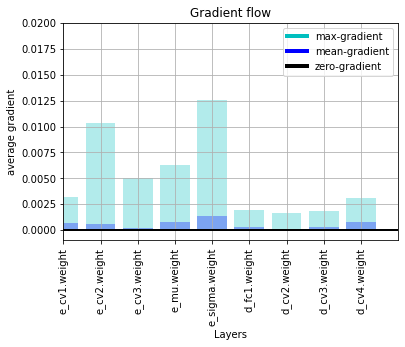

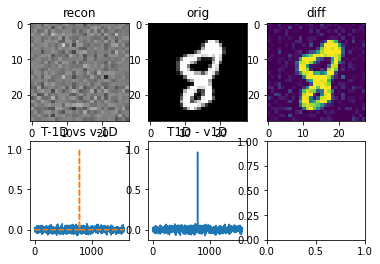

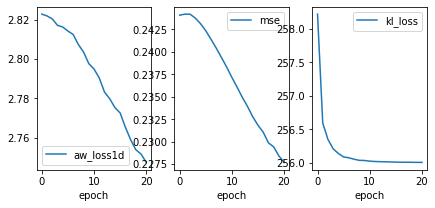

 21% (21 of 100) |####                   | Elapsed Time: 0:01:45 ETA:   0:07:28


KeyboardInterrupt: 

In [9]:
model = CVAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)